## Задание

Мы будем работать с (частичными) данными lenta.ru отсюда: https://www.kaggle.com/yutkin/corpus-of-russian-news-articles-from-lenta/ Ниже примерный список того, что можно попробовать в ходе решения.

1. Проведите предобработку текста: уберите небуквенные символы, проведите токенизацию, лемматизируйте текст. Разбейте данные на train и test для задачи классификации (в качестве метки класса будем использовать поле topic_label).В качестве данных для классификации в пунктах 3 и 5 попробуйте взять
    - только заголовки (title)
    - только тексты новости (text)
    - и то, и другое
2. Обучите fastText для классификации текстов по темам (baseline).
3. Обучите свою модель w2v (или возьмите любую подходящую предобученную модель). Реализуйте функцию для вычисления вектора текста / заголовка / текста+заголовка как среднего вектора входящих в него слов. 
     - (Бонус) Модифицируйте функцию вычисления среднего вектора: взвешивайте вектора слов соответствующими весами tf-idf.
4. Обучите на полученных средних векторах алгоритм классификации (логистическая регрессия, SVM, KNN, однослойную полносвязную нейросеть). 
5. Обучите сверточную сеть, на вход можно подавать предобученные эмбеддинги из п. 4 **(для слов, не для предложений)**.

In [1]:
import re
import unicodedata
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from pymystem3 import Mystem
from functools import lru_cache
import pymorphy2
from functools import lru_cache
from multiprocessing import Pool
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
import re
import nltk
import pandas as pd
from random import randint
import fasttext
from gensim.models import word2vec
from nltk.tokenize import WordPunctTokenizer
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import *
import pickle
import matplotlib.pyplot as plt

In [ ]:
# ! pip install fastText/.

In [2]:
# ! wget -O lenta-ru-train.csv https://www.dropbox.com/s/kdupcw1llbdbqwl/lenta-ru-train.csv?dl=0

In [3]:
# lenta = pd.read_csv('lenta-ru-train.csv')
# lenta.head()

In [25]:
lenta.topic.value_counts()

Экономика          63571
Спорт              51679
Культура           43071
Наука и техника    42384
Бизнес              5931
Name: topic, dtype: int64

In [5]:
# len(lenta)

Ниже пример, как можно сделать файл с решением для Kaggle.

In [6]:
# ! wget -O lenta-ru-test.csv https://www.dropbox.com/s/9av90tgqob1slnj/lenta-ru-test.csv?dl=0

In [8]:
# topics = ['Экономика', 'Спорт', 'Культура', 'Наука и техника', 'Бизнес']
# test_data = pd.read_csv('lenta-ru-test.csv')
# test_data.head()

In [7]:
# lenta['title'][0]

In [1]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('snowball_data')
# nltk.download('perluniprops')
# nltk.download('universal_tagset')
# nltk.download('stopwords')
# nltk.download('nonbreaking_prefixes')
# nltk.download('wordnet')

In [51]:
# !pip install pymystem3

In [53]:
sw = stopwords.words('russian')

In [54]:
lenta['title'] = lenta['title'].str.replace(r'[^А-я\s]', '', regex=True).str.lower().str.split()
lenta['text'] = lenta['text'].str.replace(r'[^А-я\s]', '', regex=True).str.lower().str.split()

In [55]:
lenta['text']

0         [глава, росстата, владимир, соколин, заявил, ч...
1         [у, российских, кинематографистов, появится, н...
2         [медицинский, штаб, миланского, интера, обнаро...
3         [премии, книга, года, в, номинациях, вручены, ...
4         [сборная, португалии, сыграла, вничью, с, кома...
                                ...                        
206632    [бывшей, вицепрезиденту, ювелирной, компании, ...
206633    [минфин, предлагает, увеличить, размер, штрафа...
206634    [индекс, потребительской, уверенности, россиян...
206635    [капитан, женской, сборной, россии, по, теннис...
206636    [союз, европейских, футбольных, ассоциаций, уе...
Name: text, Length: 206637, dtype: object

In [56]:
lenta[lenta['text'].apply(lambda x: print(x) if type(x) is float else 'Nope') != 'Nope']

nan


,title,text,topic,topic_label
151352,"[гребенщиков, заработал, тысяч, рублей, в, омс...",NaN,Культура,3


In [57]:
lenta = lenta.dropna()

In [58]:
def clean(l):
    new_l = [w for w in l if w not in sw]
    return new_l

In [73]:
lenta['title'] = lenta['title'].apply(clean)
lenta['text'] = lenta['text'].apply(clean)

In [77]:
lenta.head()

,title,text,topic,topic_label
0,"(инфляция, январь, год, составлять, процент)","(глава, росстата, владимир, соколин, заявил, я...",Экономика,0
1,"(никита, михалков, учреждать, день, российский...","(российских, кинематографистов, появится, новы...",Культура,3
2,"(марко, матерацци, вернуться, строй, матч, цска)","(медицинский, штаб, миланского, интера, обнаро...",Спорт,1
3,"(определять, лауреат, премия, книга, год)","(премии, книга, года, номинациях, вручены, мос...",Культура,3
4,"(гол, роналд, штрафной, спасать, португалец, п...","(сборная, португалии, сыграла, вничью, командо...",Спорт,1


In [76]:
lenta['title'] = lenta['title'].apply(tuple)
lenta['text'] = lenta['text'].apply(tuple)

In [78]:
lemmatizer = Mystem()

In [79]:
@lru_cache(maxsize=128)
def lemm(l):
    new_l = [lemmatizer.lemmatize(word)[0] for word in l]
    return new_l

In [80]:
lenta['title'] = lenta['title'].apply(lemm)
lenta['text'] = lenta['text'].apply(lemm)

In [81]:
lenta.head()

,title,text,topic,topic_label
0,"[инфляция, январь, год, составлять, процент]","[глава, росстат, владимир, соколин, заявлять, ...",Экономика,0
1,"[никита, михалков, учреждать, день, российский...","[российский, кинематографист, появляться, новы...",Культура,3
2,"[марко, матерацци, вернуться, строй, матч, цска]","[медицинский, штаб, миланский, интер, обнародо...",Спорт,1
3,"[определять, лауреат, премия, книга, год]","[премия, книга, год, номинация, вручать, моско...",Культура,3
4,"[гол, роналд, штрафной, спасать, португалец, п...","[сборная, португалия, сыграть, вничью, команда...",Спорт,1


In [82]:
def cat(l):
    return " ".join(l)

In [83]:
lenta['title'] = lenta.title.apply(cat)
lenta['text'] = lenta.text.apply(cat)

In [86]:
lenta.to_csv('lenta_clean.csv')

In [87]:
import pickle

In [88]:
lemmfile = open('lemmpickle', 'ab')
pickle.dump(lenta, lemmfile)
lemmfile.close() 

In [89]:
lemmfileloaded = open('lemmpickle', 'rb')      
lenta_loaded = pickle.load(lemmfileloaded)

In [90]:
lenta_loaded.head()

,title,text,topic,topic_label
0,инфляция январь год составлять процент,глава росстат владимир соколин заявлять январь...,Экономика,0
1,никита михалков учреждать день российский кино,российский кинематографист появляться новый пр...,Культура,3
2,марко матерацци вернуться строй матч цска,медицинский штаб миланский интер обнародоватьс...,Спорт,1
3,определять лауреат премия книга год,премия книга год номинация вручать московский ...,Культура,3
4,гол роналд штрафной спасать португалец поражен...,сборная португалия сыграть вничью команда испа...,Спорт,1


In [2]:
lenta = pd.read_csv('lenta_clean.csv')

In [3]:
lenta.head()

,Unnamed: 0,title,text,topic,topic_label
0,0,инфляция январь год составлять процент,глава росстат владимир соколин заявлять январь...,Экономика,0
1,1,никита михалков учреждать день российский кино,российский кинематографист появляться новый пр...,Культура,3
2,2,марко матерацци вернуться строй матч цска,медицинский штаб миланский интер обнародоватьс...,Спорт,1
3,3,определять лауреат премия книга год,премия книга год номинация вручать московский ...,Культура,3
4,4,гол роналд штрафной спасать португалец поражен...,сборная португалия сыграть вничью команда испа...,Спорт,1


In [4]:
# lenta.title.apply(cat)

In [5]:
X = lenta.title.tolist()
y = lenta.topic.tolist()

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

total train examples 138446
total test examples 68190


In [7]:
with open('data.train.txt', 'w+') as outfile:
    for i in range(len(X_train)):
        outfile.write('__label__' + y_train[i] + ' '+ X_train[i] + '\n')
    

with open('test.txt', 'w+') as outfile:
    for i in range(len(X_test)):
        outfile.write('__label__' + y_test[i] + ' ' + X_test[i] + '\n')

In [8]:
classifier = fasttext.train_supervised('data.train.txt')
result = classifier.test('test.txt')

print('P@1:', result[1])
print('R@1:', result[2])
print('Number of examples:', result[0])

P@1: 0.9527496700395952
R@1: 0.9527496700395952
Number of examples: 68190


In [9]:
# X = lenta.text.tolist()
# y = lenta.topic.tolist()

# X, y = np.array(X), np.array(y)

# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
# print ("total train examples %s" % len(y_train))
# print ("total test examples %s" % len(y_test))

In [9]:
# with open('data.train.text.txt', 'w+') as outfile:
#     for i in range(len(X_train)):
#         outfile.write('__label__' + y_train[i] + ' '+ X_train[i] + '\n')
    

# with open('test.text.txt', 'w+') as outfile:
#     for i in range(len(X_test)):
#         outfile.write('__label__' + y_test[i] + ' ' + X_test[i] + '\n')

In [ ]:
# classifier = fasttext.train_supervised('data.train.text.txt')
# result = classifier.test('test.text.txt')

# print('P@1:', result[1])
# print('R@1:', result[2])
# print('Number of examples:', result[0])

In [6]:
lenta['title'] = lenta['title'].str.split()

In [7]:
lenta.head()

,Unnamed: 0,title,text,topic,topic_label
0,0,"[инфляция, январь, год, составлять, процент]",глава росстат владимир соколин заявлять январь...,Экономика,0
1,1,"[никита, михалков, учреждать, день, российский...",российский кинематографист появляться новый пр...,Культура,3
2,2,"[марко, матерацци, вернуться, строй, матч, цска]",медицинский штаб миланский интер обнародоватьс...,Спорт,1
3,3,"[определять, лауреат, премия, книга, год]",премия книга год номинация вручать московский ...,Культура,3
4,4,"[гол, роналд, штрафной, спасать, португалец, п...",сборная португалия сыграть вничью команда испа...,Спорт,1


In [8]:
print("Training model...")

%time
model_en = word2vec.Word2Vec(lenta['title'].tolist(), workers=4, size=300, min_count=10, window=10, sample=1e-3)

Training model...
CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 11.4 µs


In [9]:
print(len(model_en.wv.vocab))

10282


In [10]:
tokenizer = WordPunctTokenizer()

In [11]:
def sent_to_vec(sent, embeddings=model_en, dim=300):
    """
        sent: строка
        embeddings: наше векторное представление
        dim: размер любого вектора в нашем представлении
        
        return: векторное представление
    """
    words = sent
    n_known = 0
    result = np.array([0] * dim, dtype=float)
    
    for word in words:
        if word in embeddings:
            result += embeddings[word]
            n_known += 1
            
    if n_known != 0:
        return result/n_known
    else:
        return result

In [12]:
sent_to_vec(lenta['title'].tolist()[0], model_en, dim=300).__len__()

/home/care1e55/progz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/care1e55/progz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


300

In [13]:
lenta['title'] = lenta.title.apply(sent_to_vec)

/home/care1e55/progz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/care1e55/progz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


In [15]:
lemmfile = open('embeddedPickle', 'ab')
pickle.dump(lenta, lemmfile)
lemmfile.close() 

In [43]:
lenta.head()

,Unnamed: 0,title,text,topic,topic_label
0,0,"[0.3610496371984482, 0.007361000962555408, 0.4...",глава росстат владимир соколин заявлять январь...,Экономика,0
1,1,"[0.12762553182741007, -0.30284316278994083, 0....",российский кинематографист появляться новый пр...,Культура,3
2,2,"[0.49065515398979187, -0.282268467048804, 0.29...",медицинский штаб миланский интер обнародоватьс...,Спорт,1
3,3,"[0.01280461549758911, -0.21359971445053816, -0...",премия книга год номинация вручать московский ...,Культура,3
4,4,"[0.4879233301617205, -0.16394322959240526, 0.2...",сборная португалия сыграть вничью команда испа...,Спорт,1


In [41]:
X = lenta.title.tolist()
y = lenta.topic_label.tolist()

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

total train examples 138446
total test examples 68190


In [42]:
X_train

array([[ 0.15602925,  0.18723631, -0.00665248, ...,  0.11559535,
        -0.17611851,  0.24776987],
       [-0.00956725, -0.08813083,  0.16333235, ..., -0.00676672,
        -0.11926061,  0.11858968],
       [ 0.13244015, -0.05870396,  0.38968799, ..., -0.21529333,
        -0.17672742, -0.05677   ],
       ...,
       [-0.08830607, -0.18191948,  0.30863698, ..., -0.09078639,
         0.17584103, -0.03665824],
       [-0.20363022, -0.3779142 ,  0.19975127, ...,  0.00455517,
         0.04931154,  0.02038136],
       [ 0.03093957,  0.44161596,  0.25417637, ..., -0.19768327,
        -0.52871687, -0.19915154]])

In [20]:
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.91      0.82      0.87     23484
           1       0.93      0.94      0.94     16905
           2       0.79      0.82      0.81     13367
           3       0.85      0.83      0.84     14392
           4       0.01      0.33      0.01        42

    accuracy                           0.85     68190
   macro avg       0.70      0.75      0.69     68190
weighted avg       0.88      0.85      0.87     68190



/home/care1e55/progz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [23]:
clf = SVC(random_state=42)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88     23687
           1       0.94      0.95      0.95     16816
           2       0.82      0.85      0.83     13295
           3       0.87      0.85      0.86     14392
           4       0.00      0.00      0.00         0

    accuracy                           0.87     68190
   macro avg       0.71      0.70      0.70     68190
weighted avg       0.90      0.87      0.88     68190



/home/care1e55/progz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
clf = KNeighborsClassifier(n_jobs=4)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

           0       0.91      0.81      0.86     23584
           1       0.92      0.94      0.93     16661
           2       0.79      0.82      0.80     13461
           3       0.83      0.83      0.83     14043
           4       0.08      0.35      0.12       441

    accuracy                           0.85     68190
   macro avg       0.70      0.75      0.71     68190
weighted avg       0.87      0.85      0.85     68190



In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from collections import defaultdict

In [45]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [116]:
model = Sequential()
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [114]:
# model.summary()

In [51]:
es = EarlyStopping(monitor='val_accuracy', patience=10)
steplr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

In [54]:
%%time 
# гоняем сетку три эпохи
hist = model.fit(X_train, y_train, callbacks=[es, steplr], validation_split=0.15, epochs=50, batch_size=64)

Train on 117679 samples, validate on 20767 samples
Epoch 1/50
117679/117679 [==============================] - 3s 25us/sample - loss: 0.4176 - accuracy: 0.8610 - val_loss: 0.4014 - val_accuracy: 0.8652
Epoch 2/50
117679/117679 [==============================] - 3s 26us/sample - loss: 0.4165 - accuracy: 0.8614 - val_loss: 0.3988 - val_accuracy: 0.8657
Epoch 3/50
117679/117679 [==============================] - 3s 25us/sample - loss: 0.4153 - accuracy: 0.8615 - val_loss: 0.3954 - val_accuracy: 0.8664
Epoch 4/50
117679/117679 [==============================] - 3s 24us/sample - loss: 0.4136 - accuracy: 0.8624 - val_loss: 0.3965 - val_accuracy: 0.8666
Epoch 5/50
117679/117679 [==============================] - 3s 26us/sample - loss: 0.4129 - accuracy: 0.8625 - val_loss: 0.3949 - val_accuracy: 0.8673
Epoch 6/50
117679/117679 [==============================] - 3s 23us/sample - loss: 0.4128 - accuracy: 0.8629 - val_loss: 0.3950 - val_accuracy: 0.8664
Epoch 7/50
117679/117679 [=================

Epoch 47/50
117679/117679 [==============================] - 3s 26us/sample - loss: 0.3735 - accuracy: 0.8743 - val_loss: 0.3805 - val_accuracy: 0.8731
Epoch 48/50
117679/117679 [==============================] - 3s 25us/sample - loss: 0.3736 - accuracy: 0.8742 - val_loss: 0.3805 - val_accuracy: 0.8730
Epoch 49/50
116288/117679 [============================>.] - ETA: 0s - loss: 0.3747 - accuracy: 0.8746
Epoch 00049: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
117679/117679 [==============================] - 3s 26us/sample - loss: 0.3747 - accuracy: 0.8746 - val_loss: 0.3805 - val_accuracy: 0.8729
Epoch 50/50
117679/117679 [==============================] - 3s 26us/sample - loss: 0.3748 - accuracy: 0.8741 - val_loss: 0.3805 - val_accuracy: 0.8730
CPU times: user 3min 53s, sys: 21.1 s, total: 4min 14s
Wall time: 2min 32s


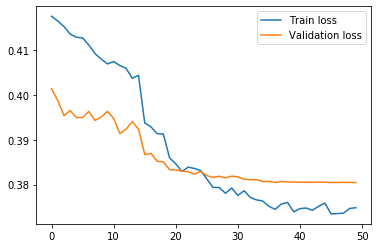

In [57]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

In [2]:
lenta = pd.read_csv('lenta_clean.csv')

In [3]:
lenta.head()

,Unnamed: 0,title,text,topic,topic_label
0,0,инфляция январь год составлять процент,глава росстат владимир соколин заявлять январь...,Экономика,0
1,1,никита михалков учреждать день российский кино,российский кинематографист появляться новый пр...,Культура,3
2,2,марко матерацци вернуться строй матч цска,медицинский штаб миланский интер обнародоватьс...,Спорт,1
3,3,определять лауреат премия книга год,премия книга год номинация вручать московский ...,Культура,3
4,4,гол роналд штрафной спасать португалец поражен...,сборная португалия сыграть вничью команда испа...,Спорт,1


In [4]:
lenta = lenta.dropna()

In [5]:
# lenta['title'] = lenta['title'].str.split()
lenta['text'] = lenta['text'].str.split()

In [6]:
# print("Training model...")

# %time
# model_en = word2vec.Word2Vec(lenta['title'].tolist(), workers=4, size=300, min_count=10, window=10, sample=1e-3)

In [7]:
lenta.head()

,Unnamed: 0,title,text,topic,topic_label
0,0,инфляция январь год составлять процент,"[глава, росстат, владимир, соколин, заявлять, ...",Экономика,0
1,1,никита михалков учреждать день российский кино,"[российский, кинематографист, появляться, новы...",Культура,3
2,2,марко матерацци вернуться строй матч цска,"[медицинский, штаб, миланский, интер, обнародо...",Спорт,1
3,3,определять лауреат премия книга год,"[премия, книга, год, номинация, вручать, моско...",Культура,3
4,4,гол роналд штрафной спасать португалец поражен...,"[сборная, португалия, сыграть, вничью, команда...",Спорт,1


In [49]:
# def words_to_vec(sent, embeddings=model_en, dim=300):
    
#     words = sent
#     n_known = 0
    
#     result = []
    
#     for word in words:
#         if word in embeddings:
#             result.append(embeddings[word])
#             n_known += 1
            
#     if n_known != 0:
#         return result
#     else:
#         return np.array([0] * dim, dtype=float)

In [11]:
words_count = defaultdict(lambda: 0)

for text in lenta.text:
    for word in text:
        words_count[word] +=1
        
len(words_count)

220560

In [12]:
top_words = 24999    # ограниичимся словарём из 25000 самых частых слов

sorted_words = sorted(words_count.items(), key=lambda w:w[1], reverse=True)
freq_words = {item[0] for item in sorted_words[:top_words]}

encoder = dict(zip(freq_words, list(range(1,len(freq_words) + 1))))

# функция-фильтр
def freq_filter(text):
    return np.array([encoder[word] for word in text if word in freq_words])

lenta['freq_text'] = lenta.text.apply(freq_filter)
lenta.head()

,Unnamed: 0,title,text,topic,topic_label,freq_text
0,0,инфляция январь год составлять процент,"[глава, росстат, владимир, соколин, заявлять, ...",Экономика,0,"[3756, 21019, 6447, 8504, 18642, 6801, 2316, 7..."
1,1,никита михалков учреждать день российский кино,"[российский, кинематографист, появляться, новы...",Культура,3,"[18103, 22699, 105, 22189, 10825, 22090, 16611..."
2,2,марко матерацци вернуться строй матч цска,"[медицинский, штаб, миланский, интер, обнародо...",Спорт,1,"[21499, 10674, 20382, 2840, 10588, 22189, 6225..."
3,3,определять лауреат премия книга год,"[премия, книга, год, номинация, вручать, моско...",Культура,3,"[21388, 7888, 2316, 18149, 18252, 1703, 21390,..."
4,4,гол роналд штрафной спасать португалец поражен...,"[сборная, португалия, сыграть, вничью, команда...",Спорт,1,"[5714, 21204, 10491, 607, 20882, 14063, 3984, ..."


In [124]:
# words_to_vec(lenta['title'].tolist()[0], model_en, dim=300)

In [126]:
# lenta['title'] = lenta.title.apply(words_to_vec)

In [28]:
# X_train[0]

In [128]:
# X = lenta.title.tolist()
# y = lenta.topic_label.tolist()

# X, y = np.array(X), np.array(y)

# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
# print ("total train examples %s" % len(y_train))
# print ("total test examples %s" % len(y_test))

In [13]:
X = lenta.freq_text.tolist()
y = lenta.topic_label.tolist()

X, y = np.array(X), np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

total train examples 138358
total test examples 68147


In [14]:
max_twitter_length = 20         # обрежем все посты до 20 слов

X_train = sequence.pad_sequences(X_train, maxlen=max_twitter_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_twitter_length)

In [15]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [16]:
es = EarlyStopping(monitor='val_accuracy', patience=10)
steplr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

In [30]:
model = Sequential()
model.add(Embedding(top_words + 1, 300, input_length=max_twitter_length))
model.add(Dropout(0.5))
model.add(LSTM(128))
# model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 20, 300)           7500000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 300)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 645       
Total params: 7,720,293
Trainable params: 7,720,293
Non-trainable params: 0
_________________________________________________________________


In [32]:
%%time 
hist = model.fit(X_train, y_train, callbacks=[es, steplr], validation_split=0.15, epochs=5, batch_size=64)

Train on 117604 samples, validate on 20754 samples
Epoch 1/5
117604/117604 [==============================] - 79s 668us/sample - loss: 0.3402 - accuracy: 0.8909 - val_loss: 0.2770 - val_accuracy: 0.9153
Epoch 2/5
117604/117604 [==============================] - 79s 668us/sample - loss: 0.2125 - accuracy: 0.9330 - val_loss: 0.2724 - val_accuracy: 0.9158
Epoch 3/5
117604/117604 [==============================] - 79s 669us/sample - loss: 0.1642 - accuracy: 0.9473 - val_loss: 0.2946 - val_accuracy: 0.9122
Epoch 4/5
117604/117604 [==============================] - 80s 681us/sample - loss: 0.1237 - accuracy: 0.9594 - val_loss: 0.3201 - val_accuracy: 0.9130
Epoch 5/5
117568/117604 [============================>.] - ETA: 0s - loss: 0.0926 - accuracy: 0.9697
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
117604/117604 [==============================] - 81s 689us/sample - loss: 0.0926 - accuracy: 0.9697 - val_loss: 0.3618 - val_accuracy: 0.9088
CPU times: user 29

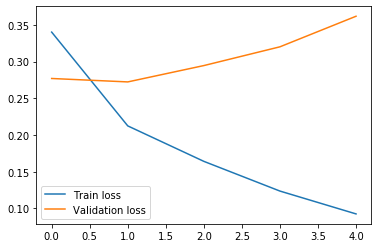

In [34]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

In [47]:
model = Sequential()
model.add(Embedding(top_words + 1, 300, input_length=max_twitter_length))
model.add(Conv1D(64, 2, activation='relu'))
model.add(GlobalMaxPooling1D())
# model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [48]:
%%time 
hist = model.fit(X_train, y_train, callbacks=[es, steplr], validation_split=0.15, epochs=5, batch_size=64)

Train on 117604 samples, validate on 20754 samples
Epoch 1/5
117604/117604 [==============================] - 81s 688us/sample - loss: 0.3583 - accuracy: 0.8910 - val_loss: 0.2677 - val_accuracy: 0.9153
Epoch 2/5
117604/117604 [==============================] - 80s 676us/sample - loss: 0.1781 - accuracy: 0.9437 - val_loss: 0.2764 - val_accuracy: 0.9164
Epoch 3/5
117604/117604 [==============================] - 80s 677us/sample - loss: 0.0920 - accuracy: 0.9721 - val_loss: 0.3238 - val_accuracy: 0.9146
Epoch 4/5
117604/117604 [==============================] - 81s 689us/sample - loss: 0.0424 - accuracy: 0.9884 - val_loss: 0.3872 - val_accuracy: 0.9093
Epoch 5/5
117568/117604 [============================>.] - ETA: 0s - loss: 0.0246 - accuracy: 0.9943
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
117604/117604 [==============================] - 79s 674us/sample - loss: 0.0246 - accuracy: 0.9943 - val_loss: 0.4430 - val_accuracy: 0.9096
CPU times: user 29

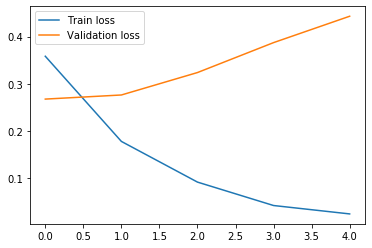

In [50]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['Train loss', 'Validation loss'])

In [7]:
test_data['label'] = [topics[randint(0,4)] for i in range(len(test_data)) ]
test_data.head()

,title,text,label
0,Сборная России выиграла чемпионат мира по футб...,В южноафриканском Кейптауне победой сборной Ро...,Экономика
1,Анна Курникова снова проиграла в первом раунде,"Анна Курникова, проиграв испанке Кончите Марти...",Спорт
2,"Новым главным тренером ""Спартака"" стал Станисл...",Новым главным тренером московского футбольного...,Спорт
3,Майкл Дуглас совершил неожиданный визит на Кубу,Известный голливудский актер Майкл Дуглас сове...,Экономика
4,Кадыров снялся в короткометражке «Волшебный гр...,Глава Чеченской Республики Рамзан Кадыров снял...,Культура


In [8]:
test_data['label'].to_csv('submission.csv', header = None)